# Laboratory 5 - Systems of linear equation
#### Grzegorz Fotyga

## 1 Introduction

The aim of the following laboratory is to use various algorithms to solve systems of linear equations. The analyzed systems of equations are related to the PageRank algorithm, which was discussed in previous classes. In this laboratory, it is crucial to observe the effectiveness of individual algorithms.


### Task 1

The following code is used to generate the matrix: Edges. It contains links in a network of sites. Based on the connections, we generate matrices related to the PageRank algorithm. Solving the system of linear equations will allow you to determine the ranking of the pages (just like in the previous classes). Note - the codes below are only for generating Edges arrays. Understanding them is not necessary to complete subsequent tasks.

Generate network with 2000 sites and dnsity of connection: 20. 

In [7]:
import numpy as np

def remove_duplicate_columns(matrix):
    unique_columns = np.unique(matrix, axis=1)
    return unique_columns

def generate_network(N, density):
    Edges = np.random.randint(1, N+1, size=(2, int(N * density)))
    Edges = np.delete(Edges, np.where(Edges[0] == Edges[1]), axis=1)
    Edges = remove_duplicate_columns(Edges)
    return Edges


n = 2000  # number of sites
density = 20  # density of connections in the network
Edges = generate_network(n, density)
print("number of connections in the network:", Edges.shape[1])  # print number of connections

number of connections in the network: 39801


### Task 2

Generate matrices related to the PageRank algorithm based on the network. Create an appropriate function that generates PageRank matrices and can be used in subsequent tasks.

In [8]:
from scipy.sparse import csr_matrix
from scipy.sparse import identity
import matplotlib.pyplot as plt 

d = 0.1  # dumping factor
b = np.ones(n) * (1-d)/n
I = identity(n, format='csr')

B = csr_matrix((n,n))
B[Edges[1] - 1, Edges[0] - 1] = 1

L = np.zeros(n)
for i in range(n):
    L[i] = np.sum(B[:,i])

A = csr_matrix((n,n))
for i in range(n):
    A[i,i] = 1/L[i]
M = I - d * B @ A

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


### Task 3

- Solve Page Rank system of equations $\mathbf{M}\mathbf{r} = \mathbf{b}$ using *inv()* funcion from *scipy* module: $\mathbf{r} = \mathbf{M}^{-1}\mathbf{b}$. Save $\mathbf{r}$ for comparison with other methods.

- Measure the time needed for this operation (and save it for comparison with other methods).

- (and promise that this lab will be the last time you solve a system of equations this way!)

- Use function *plt.spy()* with parameter: *markersize=0.1* to observe nonzero elements of $\mathbf{M}$ and $\mathbf{M}^{-1}$ matrices. Check the memory usage of both matrices. Comment these results. 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Time taken: 2.960127830505371 seconds


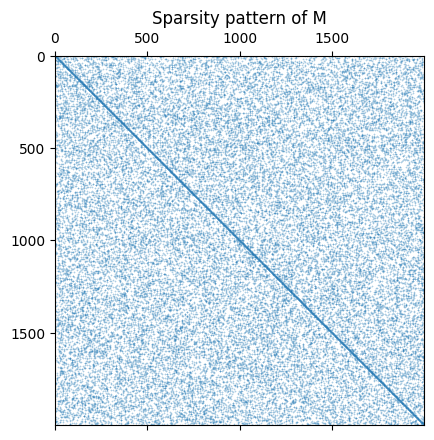

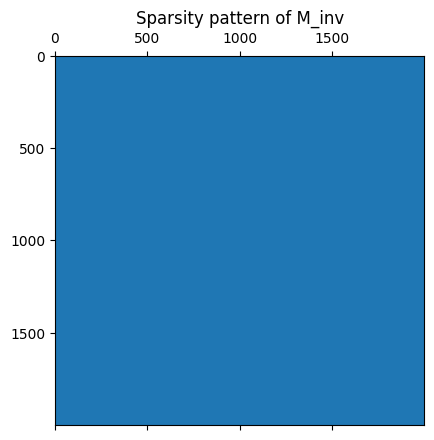

In [82]:
from scipy.sparse.linalg import inv
import time

# your code
start_time = time.time()
M_inv = inv(M) 
r = M_inv @ b 
end_time = time.time()

time_inv = end_time - start_time
print("Time taken:", time_inv, "seconds")

plt.spy(M, markersize=0.1)
plt.title("Sparsity pattern of M")
plt.show()
plt.spy(M_inv, markersize=0.1)
plt.title("Sparsity pattern of M_inv")
plt.show()


In [ ]:
import sys 
memory_usage = M.data.nbytes + M.indices.nbytes + M.indptr.nbytes
print("Memory usage of CSR matrix:", memory_usage, "bytes")
memory_usage_inv = M_inv.data.nbytes + M_inv.indices.nbytes + M_inv.indptr.nbytes
print("Memory usage of inverse CSR matrix:", memory_usage_inv, "bytes")

#memory usage of the inverse matrix is significantly larger than the original matrix

Memory usage of CSR matrix: 509616 bytes
Memory usage of inverse CSR matrix: 48008004 bytes


Your commens:

### Task 4

- Solve the same system of equations using direct method: *spsolve()*. Save $\mathbf{r}$ for comparison with other methods.
- Measure the time needed for this operation (and save it for comparison with other methods).
- Use plt.plot() function to show the difference between solutions obtained in previous tasks. What is the maximum value of the difference between these vectors?
- Compute the norm (*np.linalg.norm()*) of the the difference between these two vectors. 

Time taken using spsolve: 0.4102349281311035 seconds


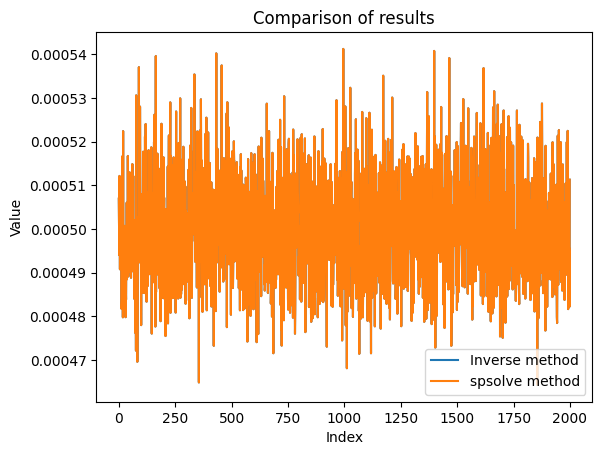

Maximum value of difference between vectors: 7.697835424647081e-18
Norm of the difference between vectors: 6.56730575397582e-17


In [80]:
from scipy.sparse.linalg import spsolve

# your code
start_time_spsolve = time.time()
r_spsolve = spsolve(M, b)
end_time_spsolve = time.time()

time_spsolve = end_time_spsolve - start_time_spsolve

print("Time taken using spsolve:", time_spsolve, "seconds")

plt.plot(r, label='Inverse method')
plt.plot(r_spsolve, label='spsolve method')
plt.title("Comparison of results")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

max_difference = np.max(np.abs(r - r_spsolve))
print("Maximum value of difference between vectors:", max_difference)

norm_difference = np.linalg.norm(r - r_spsolve)
print("Norm of the difference between vectors:", norm_difference)

### Task 5

In this task you will implement Jacobi mathod. Firstly, split $\mathbf{M}$ into 3 components: *$\textbf{M} = -\textbf{L} - \textbf{U} + \textbf{D}$*

- $\textbf{L}$ contains all elements of $\mathbf{M}$, which lie below the diagonal (without diagonal). It can be computed using *tril()*, with parameter *k = -1*, wchich means that we do not include elements from diagonal. 

- $\textbf{U}$ contains all elements of $\mathbf{M}$, which lie above the diagonal (without diagonal). It can be computed using *triu()*, with parameter *k = 1*, wchich means that we do not include elements from diagonal. 

- $\textbf{D}$ contains all elements of $\mathbf{M}$, which lie at the diagonal. In our case it is just identity matrix. 

- Use *spy()* to observe nonzero elements. 


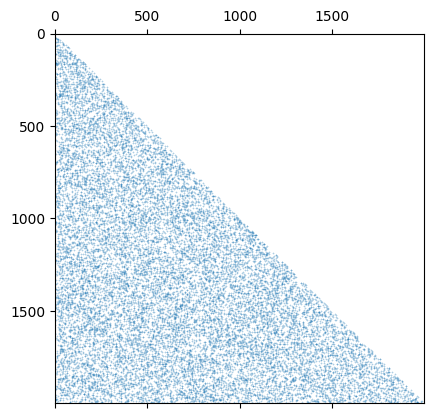

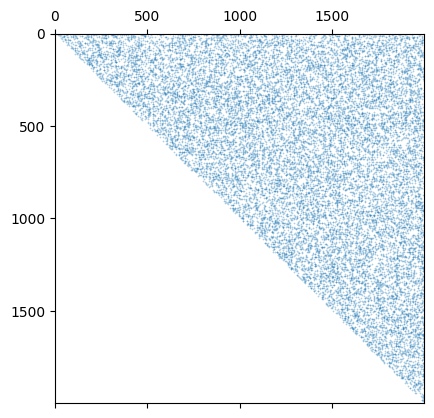

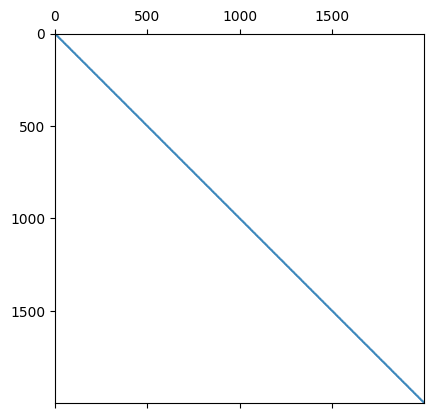

In [83]:
from scipy.sparse import csr_matrix, triu, tril
# your code

L = tril(M, -1)
L = -L
U = triu(M, 1)
U = -U
D = identity(M.shape[0], format='csr')
plt.spy(L, markersize=0.1)
plt.show()
plt.spy(U, markersize=0.1)
plt.show()
plt.spy(D, markersize=0.1)
plt.show()

### Task 6 - Jacobi

- Generate $\mathbf{r}^0$ vector of the same size as $\mathbf{b}$ vector, which is full of ones. It will be used as a starting vector for Jacobi scheme. 
- Use Jacobi scheme to solve system of equations in iterative way: $\widetilde{\textbf{r}}^{n+1} = \textbf{D}^{-1}(\textbf{L} + \textbf{U})\widetilde{\textbf{r}}^{n} + \textbf{D}^{-1}\textbf{b}$	

- Hint: $\mathbf{D}$ is an identity matrix. Do you need to explicitely compute $\mathbf{D}^{-1}$? 
- In each iteration compute the real error ($\textbf{e}^n = \textbf{r} - \widetilde{\textbf{r}}^{n} $, where $\textbf{r}$ is a solution obtained using the direct scheme (task 4)) and the residual error ($\textbf{res}^n = \textbf{M}\widetilde{\textbf{r}}^n - \textbf{b}$)
- Observe the NORM of these error vectors in subsequent iterations. 
- Stop iterative scheme once the NORM of the residual error falls below the value 1e-12.

Time taken using Jacobi method: 0.012226104736328125 seconds


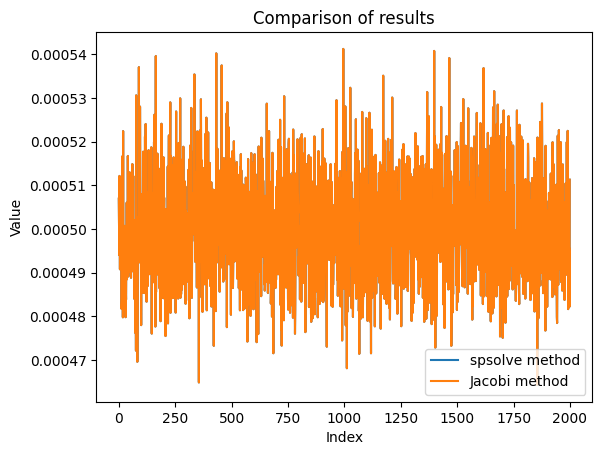

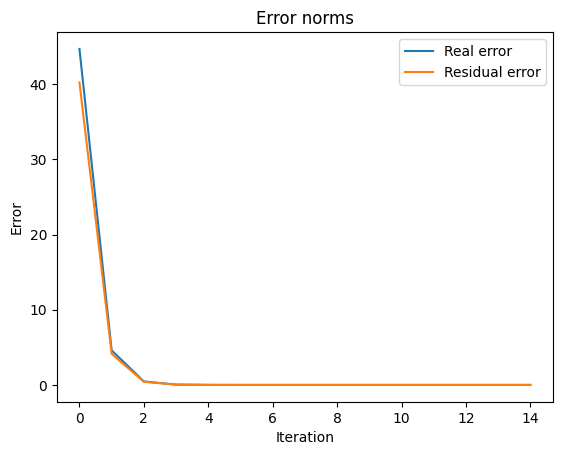

In [88]:
# your code
r0 = np.ones_like(b)

real_errors = []
residual_errors = []

tolerance = 1e-12

start_time_jacobi = time.time()

while True:
    r_next = (L + U) @ r0 + b 
    e = r_spsolve - r0
    res = M @ r0 - b

    real_errors.append(np.linalg.norm(e))
    residual_errors.append(np.linalg.norm(res))

    if np.linalg.norm(res) < tolerance:
        break

    r0 = r_next
    iterations += 1

end_time_jacobi = time.time()
time_jacobi = end_time_jacobi - start_time_jacobi
print("Time taken using Jacobi method:", time_jacobi, "seconds")

plt.plot(r_spsolve, label='spsolve method')
plt.plot(r0, label='Jacobi method')
plt.title("Comparison of results")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()
plt.plot(real_errors, label='Real error')
plt.plot(residual_errors, label='Residual error')
plt.title("Error norms")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.legend()
plt.show()

### Task 7

Compare the computational times of three methods: inv, direct and Jacobi.  

### Task 8 - additional

implement Gauss - Seidel scheme.
 
$\widetilde{\textbf{r}}^{n+1} = (\textbf{D -L})^{-1}(\textbf{U} \widetilde{\textbf{r}}^{n}) + (\textbf{D -L})^{-1}\textbf{b}$

In [ ]:
# your code